# Defining the prior using speedystar and Gaia

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table
import sys


# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
from scripts.CMD_selection import *
from scripts.hvs_healpix_prior import *
from scripts.catalog_preparation.prepare_gaia import *
from scripts.misc.fft_kde import WeightedFFTKDE
#from classifier import BayesianKDEClassifier

# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})

# Enable LaTeX rendering
plt.rc('text', usetex=True)


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# We will begin by building the map showing the density of stars per healpix pixel

In [2]:
# data = pd.read_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/CMD_training_catalogs/kappa_1.7_speedystar_with_probabilities.csv')
# data_hvs = data.loc[data['is_hvs'] == 1]

# # make sure that the stars will be observable by Gaia
# data_hvs = data_hvs.loc[data_hvs['phot_g_mean_mag'] < 21]
data_hvs = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock_long.fits')

data_hvs = prepare_speedystar(data_hvs)

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
# make coordinates into galactic coordinates
from astropy.coordinates import SkyCoord

coords = SkyCoord(ra=data_hvs['ra'], dec=data_hvs['dec'], frame='icrs', unit='deg')
data_hvs['l'] = coords.galactic.l.deg
data_hvs['b'] = coords.galactic.b.deg

In [4]:
# plot selected stars in the sky next to a dustmap

import dustmaps.sfd
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

In [5]:
# prepare reddening map plot
# construct all sky reddening map
l_range = np.arange(0, 365, 0.1)
b_range = np.arange(-90, 90, 0.1)
l, b = np.meshgrid(l_range,b_range )
coord_map = SkyCoord(l*u.deg, b*u.deg, distance = 100.*u.kpc, frame =  'galactic')

sfd = SFDQuery()
Av_sfd = 2.742 * sfd(coord_map)
Av_sfd_sim = 2.742 * sfd(coords)

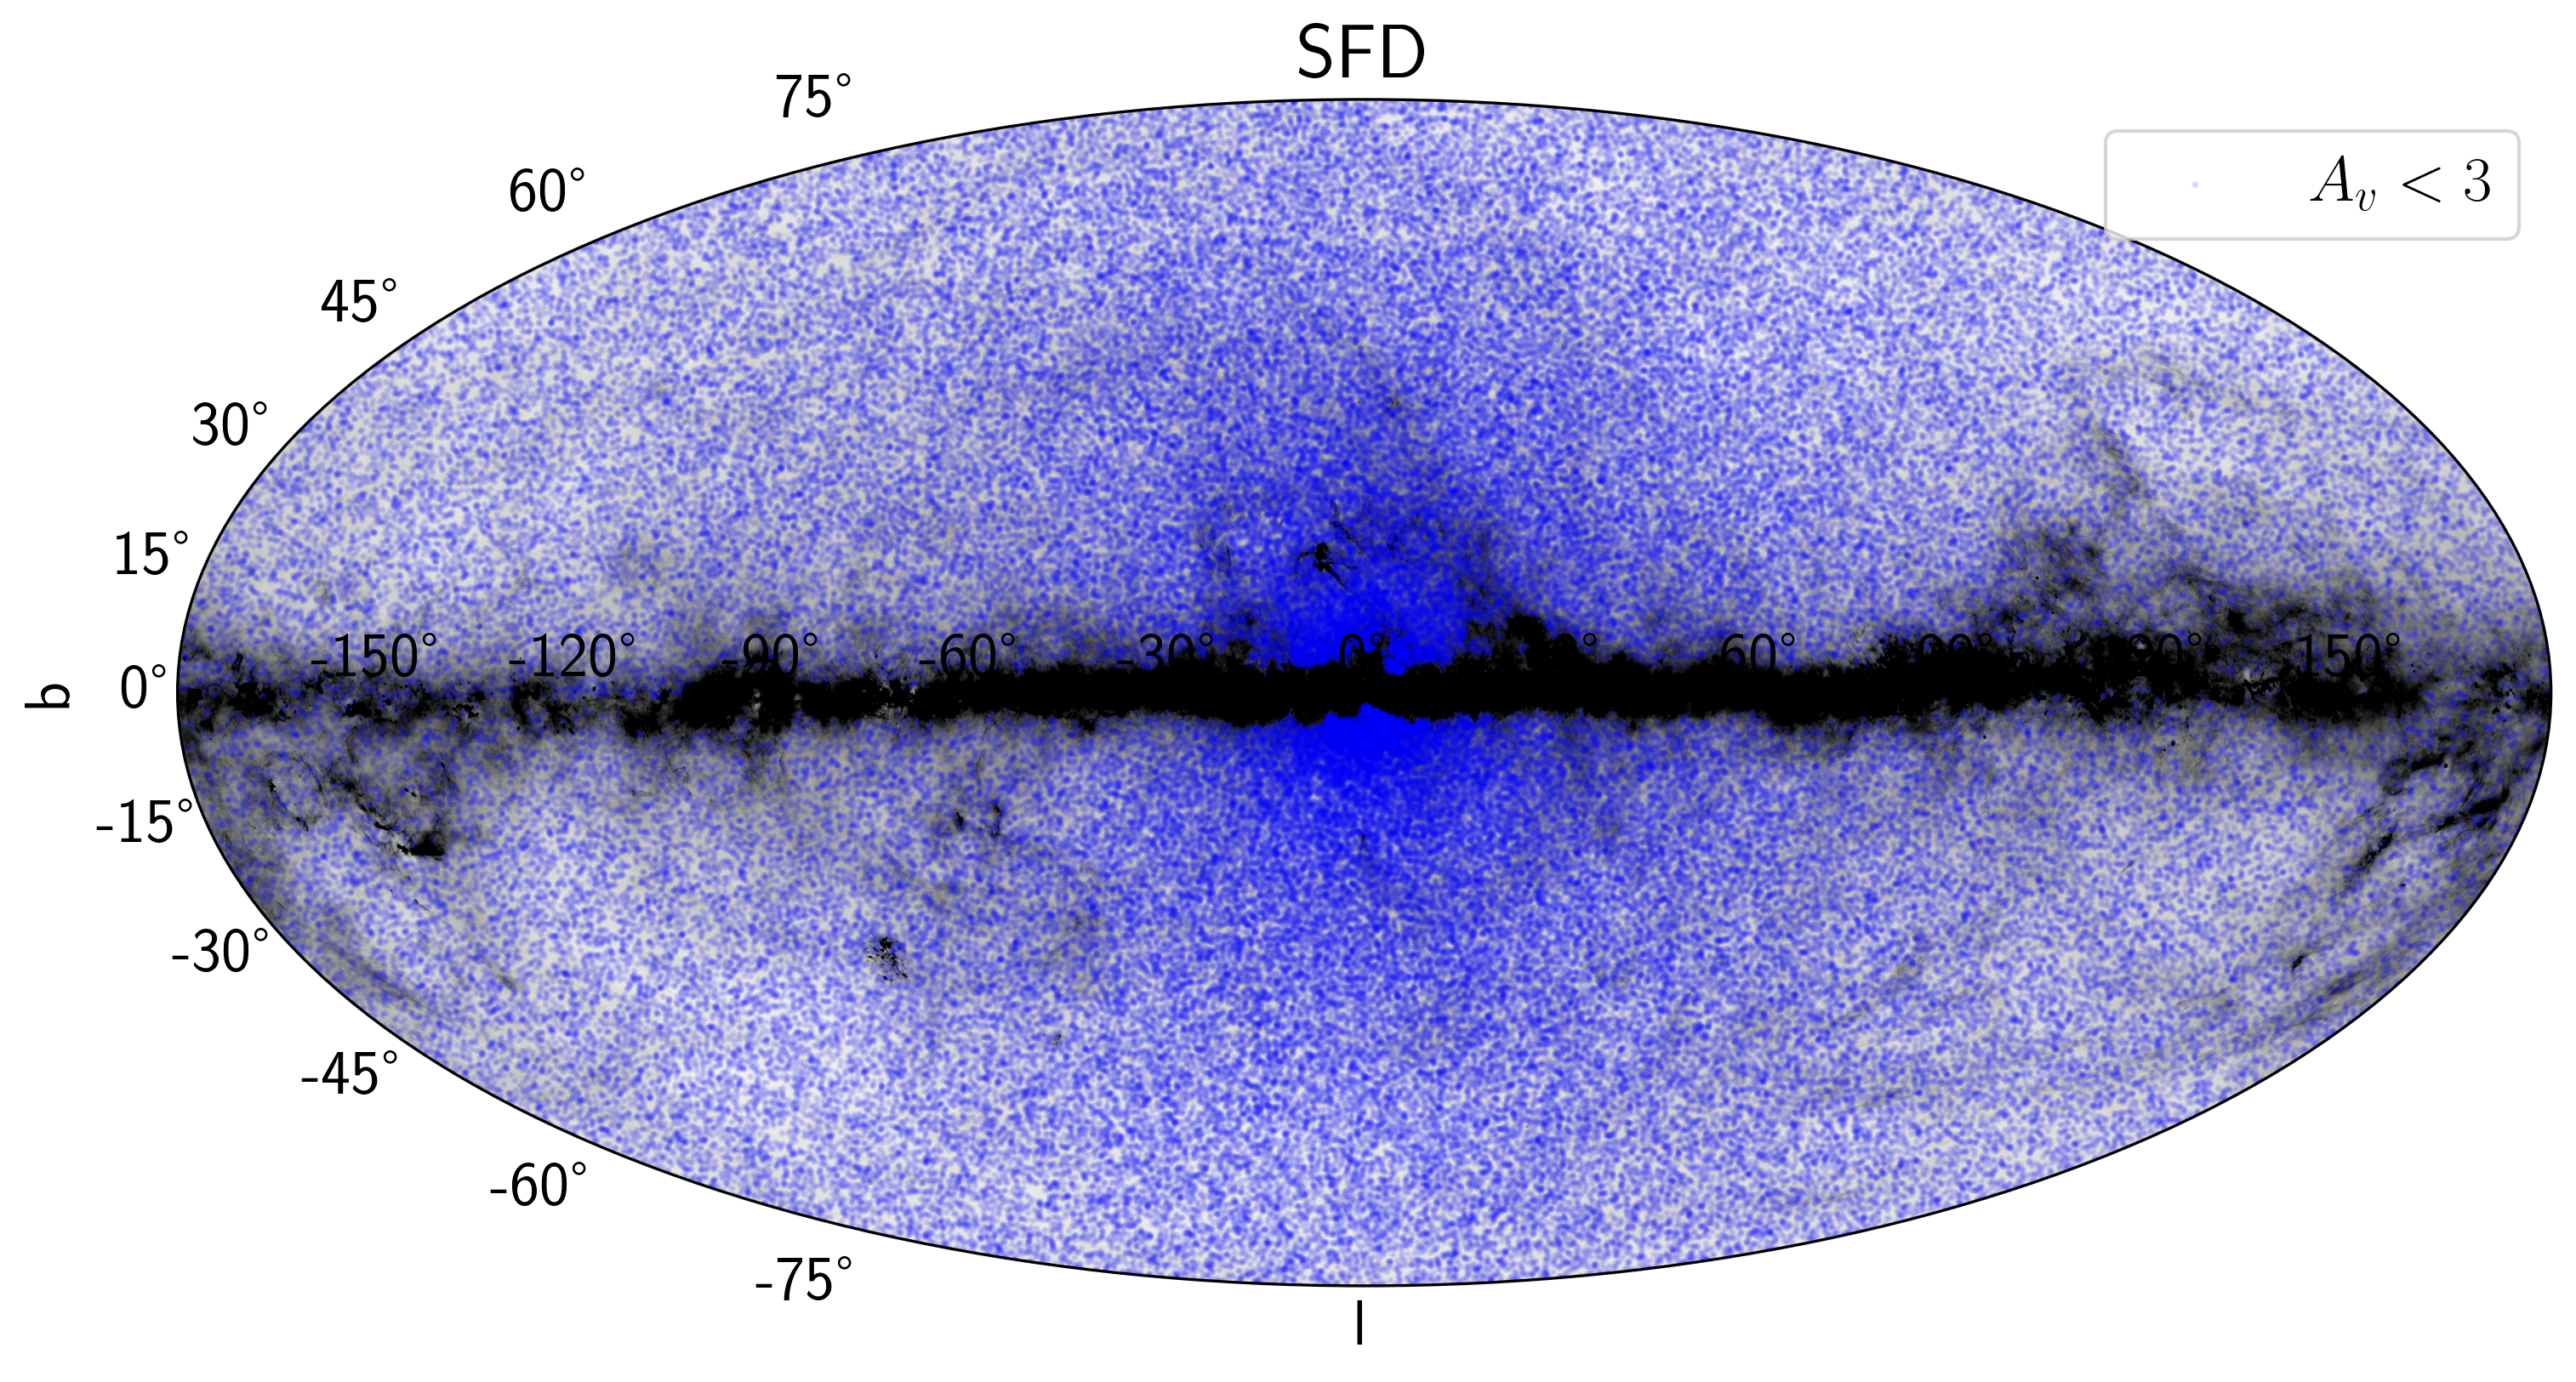

In [6]:
# mollwide plot with colormesh
fig = plt.figure(figsize=(12,7), dpi=300)
ax = fig.add_subplot(111, projection = 'mollweide')
limit  = 3
data_ag = data_hvs.loc[data_hvs['A_G'] <  limit]
data_av = data_hvs.loc[Av_sfd_sim <  limit]
ax.pcolormesh(np.radians(l- 180) + np.pi , np.radians(b), np.sqrt(Av_sfd), cmap = 'binary', shading = 'nearest', vmin=0., vmax=2.,)
ax.pcolormesh(np.radians(l- 180) - np.pi , np.radians(b), np.sqrt(Av_sfd), cmap = 'binary', shading = 'nearest', vmin=0., vmax=2.,)

#ax.scatter(data_ag['l']-180, data_ag['b'], s=1, alpha=1, label=f'$A_g < {limit}$')
#ax.scatter(np.radians(data_av['l']), np.radians(data_av['b']), s=1, alpha=1, label=f'$A_v < {limit}$')

ax.scatter(np.radians(data_av['l']- 180) + np.pi, np.radians(data_av['b']), s=1, alpha=0.1, label=f'$A_v < {limit}$', c = 'blue')
ax.scatter(np.radians(data_av['l']- 180) - np.pi, np.radians(data_av['b']), s=1, alpha=0.1, c = 'blue')
#ax.scatter(clu.l, clu.b, s= 14, c = 'y', label = 'Clustered')
plt.legend(loc = 'upper right')
plt.xlabel('l')
plt.ylabel('b')
plt.title('SFD')
plt.show()

In [ ]:
def compute_prior_hvs(l, b, nside=16):
    """
    Computes the prior probability of finding a hypervelocity star (HVS) in a HEALPix pixel
    based on the fraction of HVS in each pixel relative to the total.

    Parameters:
    ----------
    l : array-like
        Galactic longitude of HVS in degrees (simulated).
    b : array-like
        Galactic latitude of HVS in degrees (simulated).
    nside : int
        The HEALPix resolution parameter.

    Returns:
    -------
    prior_dict : dict
        Dictionary with HEALPix pixel indices as keys and priors as values.
    """
    if not isinstance(l, np.ndarray):
        l = np.array(l)
    if not isinstance(b, np.ndarray):
        b = np.array(b)

    # Check for valid ranges of Galactic coordinates
    if np.any(l < 0) or np.any(l > 360):
        raise ValueError("Galactic longitude (l) must be in the range [0, 360] degrees.")
    if np.any(b < -90) or np.any(b > 90):
        raise ValueError("Galactic latitude (b) must be in the range [-90, 90] degrees.")
    
    # Filter out invalid or masked data
    valid_mask = (~np.isnan(l)) & (~np.isnan(b)) & (~np.ma.getmaskarray(l)) & (~np.ma.getmaskarray(b))
    l_valid = l[valid_mask]
    b_valid = b[valid_mask]

    # Compute HEALPix indices for valid HVS
    hvs_pix = hp.ang2pix(nside, l_valid, b_valid, lonlat=True, nest=True)
    
    npix = hp.nside2npix(nside)
    
    # Count HVS in each pixel
    hvs_counts = Counter(hvs_pix)
    n_hvs_total = sum(hvs_counts.values())  # Total number of HVS
    
    # Initialize a dict for all pixels with zero prior
    prior_dict = {pix: 0.0 for pix in range(npix)}
    
    # Update priors for pixels that have HVS
    for pix, count in hvs_counts.items():
        prior_dict[pix] = count / n_hvs_total

    return prior_dict



In [29]:
def compute_prior_hvs(ra, dec, nside=16):
    """
    Computes the prior probability of finding a hypervelocity star (HVS) in a HEALPix pixel
    based on the fraction of HVS in each pixel relative to the total.

    Parameters:
    ----------
    ra : array-like
        Right Ascension of HVS in degrees (simulated).
    dec : array-like
        Declination of HVS in degrees (simulated).
    nside : int
        The HEALPix resolution parameter.

    Returns:
    -------
    prior_dict : dict
        Dictionary with HEALPix pixel indices as keys and priors as values.
    """
    if not isinstance(ra, np.ndarray):
        ra = np.array(ra)
    if not isinstance(dec, np.ndarray):
        dec = np.array(dec)

    # Check for valid ranges of Equatorial coordinates
    if np.any(ra < 0) or np.any(ra > 360):
        raise ValueError("Right Ascension (RA) must be in the range [0, 360] degrees.")
    if np.any(dec < -90) or np.any(dec > 90):
        raise ValueError("Declination (Dec) must be in the range [-90, 90] degrees.")
    
    # Filter out invalid or masked data
    valid_mask = (~np.isnan(ra)) & (~np.isnan(dec)) & (~np.ma.getmaskarray(ra)) & (~np.ma.getmaskarray(dec))
    ra_valid = ra[valid_mask]
    dec_valid = dec[valid_mask]

    # Convert RA/Dec to theta (colatitude) and phi (longitude) in radians
    theta = np.radians(90.0 - dec_valid)  # Colatitude
    phi = np.radians(ra_valid)           # Longitude

    # Compute HEALPix indices for valid HVS
    hvs_pix = hp.ang2pix(nside, theta, phi, lonlat=False, nest=True)
    
    npix = hp.nside2npix(nside)
    
    # Count HVS in each pixel
    hvs_counts = Counter(hvs_pix)
    n_hvs_total = sum(hvs_counts.values())  # Total number of HVS
    
    # Initialize a dict for all pixels with zero prior
    prior_dict = {pix: 0.0 for pix in range(npix)}
    
    # Update priors for pixels that have HVS
    for pix, count in hvs_counts.items():
        prior_dict[pix] = count / n_hvs_total

    return prior_dict

In [30]:
# # Load the HVS catalog
# hvs_cat = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/from_MIST/test_eep_propagated_phot_MIST_1e5.fits')

# # select sources observable by Gaia
# hvs_cat = hvs_cat[hvs_cat['Gaia_G_M'] < 21]
# compute the total nside = 4 healpix pixels
healpix_level = 4
nside = 2**healpix_level
prior_dict = compute_prior_hvs(data_ag['ra'], data_ag['dec'], nside=nside)

# Make a pandas dataframe from the dictionary
prior_df = pd.DataFrame(prior_dict.items(), columns=['healpix', 'prior'])

# Save the prior dictionary as a csv file

prior_dict_path = '/Users/mncavieres/Documents/2024-2/HVS/Data/priors'
os.makedirs(prior_dict_path, exist_ok=True)
prior_dict_file = os.path.join(prior_dict_path, f'prior_dict_nside{nside}.npy')
prior_df.to_csv(prior_dict_file, index=False)

# Plot the prior map
#plot_healpix_prior(prior_dict, nside, title="Speedystar")


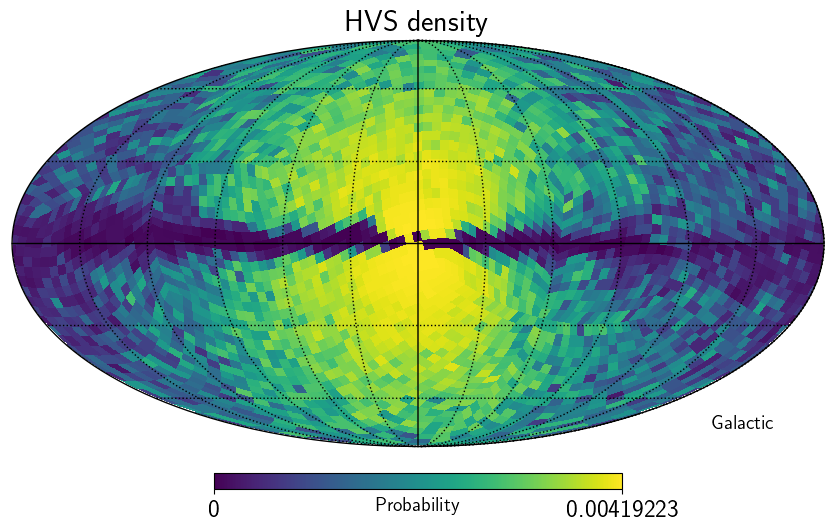

In [33]:
# Initialize a HEALPix map with zeros
npix = hp.nside2npix(nside)
healpix_map = np.zeros(npix)

# Fill the map with the probabilities from the dictionary
for pix, prob in prior_dict.items():
    healpix_map[pix] = prob

# Plot the HEALPix map
hp.mollview(healpix_map, cmap="viridis", unit="Probability", norm="hist", nest = True, coord=['C', 'G'], title='HVS density')

# Add a graticule
hp.graticule()

# Show the plot
plt.show()

# Now the Gaia source density as a function of HEALPix

In [22]:
gaia_density_healpix = pd.read_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/HEALPix_density.csv')

In [23]:
gaia_density_healpix = gaia_density_healpix.sort_values('healpix_4')

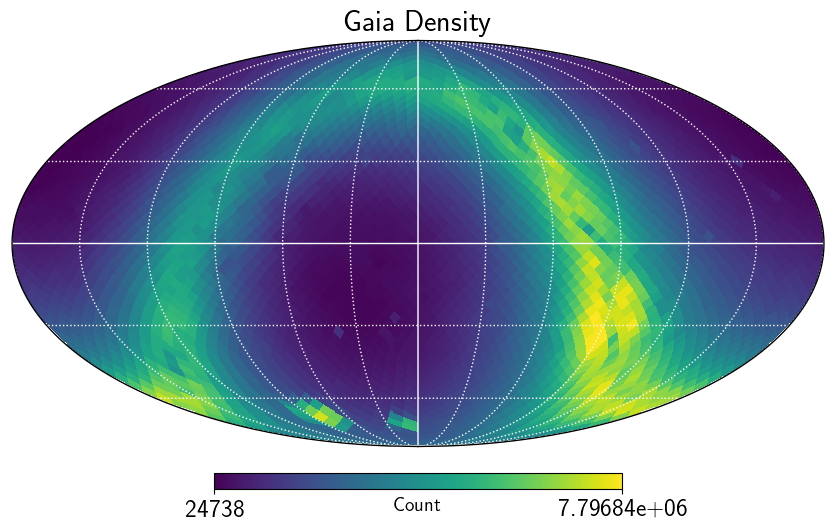

In [24]:
# Assuming healpix level 4
healpix_level = 4
nside = 2**healpix_level
npix = hp.nside2npix(nside)

# Initialize a map array
healpix_map = np.zeros(npix)
for _, row in gaia_density_healpix.iterrows():
    pix_nest = row['healpix_4']
    count = row['N']
    healpix_map[pix_nest] = count

# Plot the HEALPix map
# Since GAIA_HEALPIX_INDEX uses NEST ordering, we must set nest=True
hp.mollview(healpix_map, nest=True, cmap="viridis", unit="Count", title="Gaia Density", norm='log')#,  coord=['C','G'])
hp.graticule(color='white')

plt.show()

# Resulting prior map

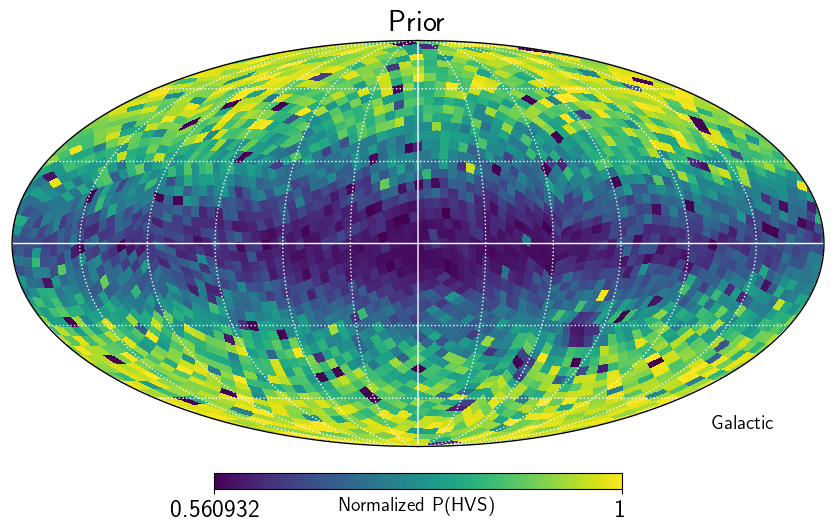

In [96]:
# the division of both previous maps
# Assuming healpix level 4
healpix_level = 4
nside = 2**healpix_level
npix = hp.nside2npix(nside)

# Initialize a map array
healpix_map = np.zeros(npix)
for i, row in gaia_density_healpix.iterrows():
    pix_nest = row['healpix_4']
    count = row['N']
    healpix_map[pix_nest] = np.abs(prior_dict[i]/(count/gaia_density_healpix['N'].max())) + 1


healpix_map = healpix_map/max(healpix_map)
# Plot the HEALPix map
# Since GAIA_HEALPIX_INDEX uses NEST ordering, we must set nest=True
hp.mollview(healpix_map, nest=True, cmap="viridis", unit="Normalized P(HVS)", title="Prior", coord=['C','G'], norm='hist')
hp.graticule(color='white')

plt.show()